In [39]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import pickle

from Embeddings import NeuralProbabilisticLM

import torch

# Initialize lists to store the extracted losses
train_losses = []
val_losses = []

# Open the file for reading
with open("log.txt", "r") as file:
    for line in file:
        # Use regular expressions to find the numbers after "Train Loss:" and "Val Loss:"
        train_match = re.search(r"Train Loss:\s*([\d.]+)", line)
        val_match = re.search(r"Val Loss:\s*([\d.]+)", line)
        
        if train_match:
            train_losses.append(float(train_match.group(1)))
        if val_match:
            val_losses.append(float(val_match.group(1)))

losses = pd.DataFrame({'train_loss': train_losses, 'val_loss': val_losses})

# Load in other data
with open('model_data/data/vocabulary.pkl', "rb") as file:
    vocabulary = pickle.load(file)

vocab, stoi, itos = vocabulary.values()

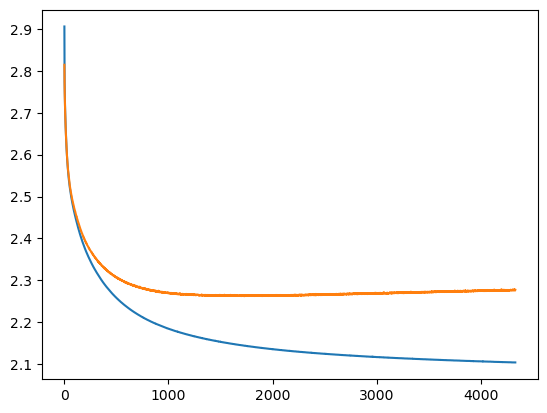

In [2]:
plt.plot(range(len(losses.train_loss)), losses.train_loss)
plt.plot(losses.val_loss)

In [4]:
losses.iloc[np.argmin(losses.val_loss)]

train_loss    2.1441
val_loss      2.2621
Name: 1728, dtype: float64

In [5]:
losses.iloc[1728]

train_loss    2.1441
val_loss      2.2621
Name: 1728, dtype: float64

In [8]:
losses.to_csv('model_data/losses.csv', index=False)

In [14]:
model = NeuralProbabilisticLM(len(vocab), window=3, emb_size=5, hidden_size=1024)
model.load_state_dict(torch.load('model_data/V2/NPLM-w3-emb5-h1024-bs64-lr1e-3-1729.pth', weights_only=True))
model.eval()

NeuralProbabilisticLM(
  (C): Embedding(31, 5)
  (layer1): Linear(in_features=15, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=31, bias=True)
)

In [18]:
model.C.weight.requires_grad = False

In [23]:
C = model.C.weight.clone()

In [25]:
scaler = StandardScaler()
C_standardized = scaler.fit_transform(C)

pca = PCA(n_components=2)  
C_pca = pca.fit_transform(C_standardized)

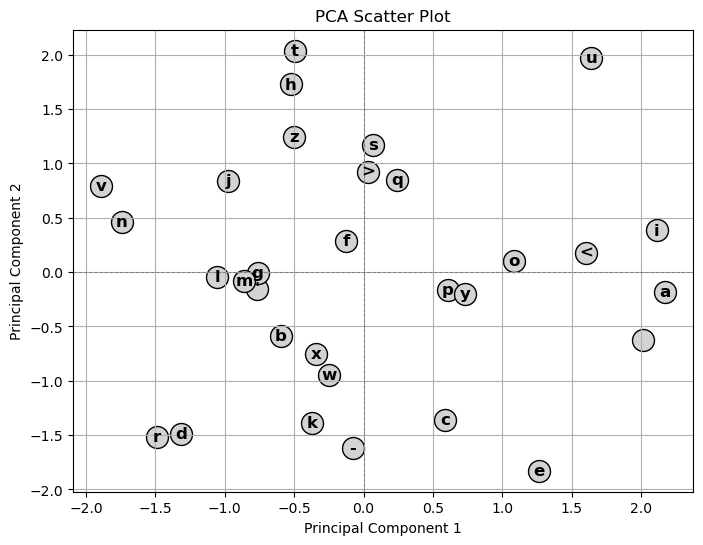

In [38]:
plt.figure(figsize=(8, 6))
plt.scatter(C_pca[:, 0], C_pca[:, 1], c='lightgrey', edgecolor='k', s=250)

for i, label in enumerate(vocab):
    plt.text(C_pca[i, 0], C_pca[i, 1], label, fontsize=12, ha='center', va='center', fontweight='bold')

# Step 5: Customize the plot
plt.title("PCA Scatter Plot")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.axhline(0, color='grey', linestyle='--', linewidth=0.7)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.7)

- Looking at PC1, we see that it differentiaes between vowels, the start token, a space vs the rest of the tokens
- THen we see that PC2 differentiates u and a from the rest of the vowels, so these two vowels are not interchangeable
- For some reason, the start token and space is very similar to the other vowels
- The ' is very similar to m and g
- The end token is very similar to s and q
- It's interesting how a and i are further away while some vowels seem to be more similar to other consonants (e and c, o and p/y)
- This could imply that a and i have special uses, perhaps the usage varies across idfferent races or something like that